# Experiment 2
Mohammad-Ali ARABI, Yashveere RAMFUL

In [69]:
#Import packages.
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as func
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql import SQLContext
from pyspark.sql import Column as col
import random as ran
#from itertools import repeat

#Create a spark session.
sparkSession = SparkSession.builder.appName("Experiment2").getOrCreate()

## Exercise 2.1 (Advanced analysis)


In [70]:
#Exercise 2.1
#loading data from users_libraries.txt into a dataframe.
#Loading the data in and RDD and splitting the paper_id id values.
userRatingsRDD = \
    sparkSession.sparkContext.textFile("/home/jovyan/work/mod_users_libraries2.txt") \
            .map(lambda line: line.split(';')) \
            .flatMapValues(lambda value: value.split(','))

#Creating the schema for the dataframe.
schemaString = "user_id paper_id"
fields = [StructField(field_name, StringType(), True) for field_name in schemaString.split()]
schema = StructType(fields)
#Creating the dataframe.
userLibDF = sparkSession.createDataFrame(userRatingsRDD, schema)
userLibDF.show(5, truncate=True)

+--------------------+--------+
|             user_id|paper_id|
+--------------------+--------+
|d0c9aaa788153daea...| 2080631|
|d0c9aaa788153daea...| 6343346|
|d0c9aaa788153daea...| 5184704|
|d0c9aaa788153daea...| 7756088|
|d0c9aaa788153daea...| 2653863|
+--------------------+--------+
only showing top 5 rows



## Exercise 2.1 (Advanced analysis)

a) Examining how many missing ratings are in the citeulike dataset by calculating the sparsity of the ratings matrix.

In [71]:
#Exercise 2.1 a)
#Number of distinct users.
numUniqUser = userLibDF.select("user_id").distinct().count()
numUniqItem = userLibDF.select("paper_id").distinct().count()
numRatings = userLibDF.select("paper_id").count()

#Calculating the sparsity of the ratings matrix.
sparsity = (((numUniqUser * numUniqItem) - numRatings)/(numUniqUser * numUniqItem)) * 100
print("Sparsity of ratings matrix = ", sparsity)

Sparsity of ratings matrix =  80.0


## Exercise 2.1 (Advanced analysis)

b) Examining the number of ratings given by the users by calculating and plotting (number of users, number of ratings) the rank-frequency distribution.

In [72]:
#Exercise 2.1 b)
userRatingInfoDF = userLibDF.select("user_id")\
                            .groupBy("user_id")\
                            .agg(func.count("user_id").alias("num_ratings_per_user"))\
                            .groupBy("num_ratings_per_user")\
                            .agg(func.count("num_ratings_per_user").alias("num_of_users"))

userRatingInfoRDD = userRatingInfoDF.rdd.map(lambda row: (row.num_ratings_per_user, row.num_of_users))
totRatingsPerUserArray = userRatingInfoRDD.map(lambda row: row[0]).collect()
numOfUsersArray = userRatingInfoRDD.map(lambda row: row[1]).collect()

userRatingInfoDF.show(10, truncate=True)

+--------------------+------------+
|num_ratings_per_user|num_of_users|
+--------------------+------------+
|                   9|           1|
|                   1|           1|
|                   3|           1|
|                  42|           1|
|                  45|           1|
+--------------------+------------+



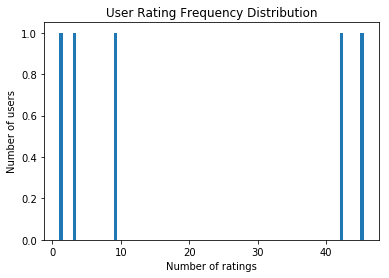

In [73]:
#Exercise 2.1 b)
plt.bar(totRatingsPerUserArray, numOfUsersArray,width=0.5, align='edge')
plt.xlabel("Number of ratings")
plt.ylabel("Number of users")
plt.title("User Rating Frequency Distribution")
plt.show()

## Exercise 2.1 (Advanced analysis)

c) Examining the papers popularity by looking at the number or ratings each paper gets. Calculating and plotting the (number of items, number of ratings) rank-frequency distribution.

In [74]:
#Exercise 2.1 c)
paperRatingInfoDF = userLibDF.select("paper_id")\
                                .groupBy("paper_id")\
                                .agg(func.count("paper_id").alias("num_ratings_per_paper"))\
                                .groupBy("num_ratings_per_paper")\
                                .agg(func.count("num_ratings_per_paper").alias("num_of_papers"))

paperRatingInfoRDD = paperRatingInfoDF.rdd.map(lambda row: (row.num_ratings_per_paper, row.num_of_papers))
totRatingsPerPaperArray = paperRatingInfoRDD.map(lambda row: row[0]).collect()
numOfPapersArray = paperRatingInfoRDD.map(lambda row: row[1]).collect()

paperRatingInfoDF.show(10, truncate=True)

+---------------------+-------------+
|num_ratings_per_paper|num_of_papers|
+---------------------+-------------+
|                    1|          100|
+---------------------+-------------+



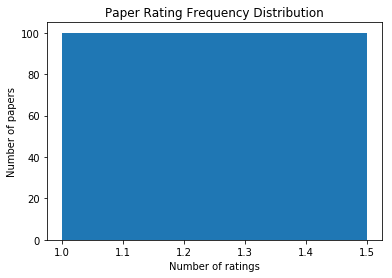

In [75]:
#Exercise 2.1 c)
plt.bar(totRatingsPerPaperArray, numOfPapersArray, width=0.5, align='edge')
plt.xlabel("Number of ratings")
plt.ylabel("Number of papers")
plt.title("Paper Rating Frequency Distribution")
plt.show()

## Exercise 2.2 (Rating matrix preparation)

Building the ratings matrix as a Dataframe with the following columns:<br>
1) user_id: a unique positive integer ID for each user.<br>
2) paper_id: a unique positive integer ID for each item.<br>
3) rating: a number (0 or 1) that represents the ratings given by the user to the item.<br>

In [76]:
#Exercise 2.2
#Generating an integer ID for the user hash ID.
mapIDToUserHashDF = userLibDF.select("user_id")\
                                .distinct()\
                                .select("user_id", func.monotonically_increasing_id().alias("gen_user_id"))

mapIDToUserHashDF.show(10, truncate=True)

+--------------------+------------+
|             user_id| gen_user_id|
+--------------------+------------+
|ca4f1ba4094011d9a...|128849018880|
|9c883d02115400f7b...|455266533376|
|f2f77383828ea6d39...|575525617664|
|d0c9aaa788153daea...|670014898176|
|d1d41a15201915503...|919123001344|
+--------------------+------------+



In [77]:
#Exercise 2.2
#Mapping the the generated user ID to its respective paper ID.
mapGenUseIDtoPaperIDDF = mapIDToUserHashDF.join(userLibDF, mapIDToUserHashDF.user_id == userLibDF.user_id, "inner")\
                                            .select("gen_user_id", "paper_id")
mapGenUseIDtoPaperIDDF.show(10, truncate=True)

+------------+--------+
| gen_user_id|paper_id|
+------------+--------+
|128849018880|  278019|
|455266533376| 3509971|
|455266533376| 3509965|
|455266533376| 2336685|
|455266533376| 2081051|
|455266533376| 3365220|
|455266533376| 1595391|
|455266533376| 4174633|
|455266533376| 1734381|
|455266533376| 3878624|
+------------+--------+
only showing top 10 rows



In [78]:
#Exercise 2.2
#Get a list of the unique paper IDs used by the users.
#Create a broadcast variable to hold the list of unique paper IDs.
uniqPaperIDList = userLibDF.select(userLibDF.paper_id).distinct().rdd.map(lambda x: x[0]).collect()
paperIDbrdcast = sparkSession.sparkContext.broadcast(uniqPaperIDList)
paperIDbrdcast.value[0:10]

['7364971',
 '7756088',
 '7469737',
 '7364823',
 '3140015',
 '7363519',
 '2363430',
 '3878624',
 '3512183',
 '6609238']

In [80]:
#Exercise 2.2
#Creating a dataframe that has a list of all the paper IDs rated by each user.
paperListPerUserDF = mapGenUseIDtoPaperIDDF.groupBy("gen_user_id")\
                                         .agg(func.collect_list("paper_id").alias("paper_id_list"))

paperListPerUserDF.show(10, truncate=True)

+------------+--------------------+
| gen_user_id|       paper_id_list|
+------------+--------------------+
|128849018880|            [278019]|
|919123001344|[6610569, 6493797...|
|670014898176|[2080631, 6343346...|
|455266533376|[3509971, 3509965...|
|575525617664|[943458, 238121, ...|
+------------+--------------------+



In [82]:
#Exercise 2.2
#Function getList returns a list of unrated paper IDS for a specific user.
#The number of paper IDs in the output list is determined by the number of papers that the user has rated.
def getList(ratedPaperList):
    
    #randomly shuffle the list of broadcast values
    ran.shuffle(paperIDbrdcast.value)
    ratedPaperSet = set(ratedPaperList)
    #generating a list of unrated paper list
    unratedPaperList = [paperID for paperID in paperIDbrdcast.value if paperID not in ratedPaperSet]
    unratedListLength = len(unratedPaperList)
    ratedListLength = len(ratedPaperList)
    
    if unratedListLength < ratedListLength:
        return unratedPaperList[0:unratedListLength]
    else:
        return unratedPaperList[0:ratedListLength]
    
#Creating a user defined function
udf_getList = udf(getList, ArrayType(StringType()))

In [83]:
#Exercise 2.2
#Creating a dataframe containing both list of rated and unrated papers.
ratedAndUnratedDF = joinPaperListPerUser.select(joinPaperListPerUser.gen_user_id,\
                                                joinPaperListPerUser.paper_id_list,\
                                                func.lit(udf_getList(joinPaperListPerUser.paper_id_list,\
                                                                    )).alias("unrated_paper_id_list"))

ratedAndUnratedDF.show(10, truncate=True)

+------------+--------------------+---------------------+
| gen_user_id|       paper_id_list|unrated_paper_id_list|
+------------+--------------------+---------------------+
|128849018880|            [278019]|            [4236212]|
|919123001344|[6610569, 6493797...| [3509971, 2445106...|
|670014898176|[2080631, 6343346...| [6609169, 6610569...|
|455266533376|[3509971, 3509965...| [6609245, 3105791...|
|575525617664|[943458, 238121, ...| [4236212, 7364973...|
+------------+--------------------+---------------------+



In [84]:
#Exercise 2.2
#Adding a rating value of "1" to the rated papers.
explodedRatedPaperDF = mapGenUseIDtoPaperIDDF.withColumn("rating", func.lit(1))
explodedRatedPaperDF.show(10, truncate=True)

+------------+--------+------+
| gen_user_id|paper_id|rating|
+------------+--------+------+
|128849018880|  278019|     1|
|455266533376| 3509971|     1|
|455266533376| 3509965|     1|
|455266533376| 2336685|     1|
|455266533376| 2081051|     1|
|455266533376| 3365220|     1|
|455266533376| 1595391|     1|
|455266533376| 4174633|     1|
|455266533376| 1734381|     1|
|455266533376| 3878624|     1|
+------------+--------+------+
only showing top 10 rows



In [85]:
#Exercise 2.2
#Exploding the dataframe to get a row for each paper id in the unrated_paper_id_list.
#Adding a rating value of "0" to the unrated papers
explodedUnratedPaperDF = ratedAndUnratedDF.select("gen_user_id",\
                                        "unrated_paper_id_list")\
                                    .withColumn("paper_id",\
                                               func.explode(ratedAndUnratedDF.unrated_paper_id_list))\
                                    .drop("unrated_paper_id_list")\
                                    .withColumn("rating", func.lit(0))
explodedUnratedPaperDF.show(10, truncate=True)

+------------+--------+------+
| gen_user_id|paper_id|rating|
+------------+--------+------+
|128849018880| 1959511|     0|
|919123001344|  943458|     0|
|919123001344| 3509965|     0|
|919123001344| 2081051|     0|
|919123001344|  226864|     0|
|919123001344|  763429|     0|
|919123001344| 5441098|     0|
|919123001344| 3140015|     0|
|919123001344| 7756088|     0|
|919123001344| 1012525|     0|
+------------+--------+------+
only showing top 10 rows



In [87]:
#Exercise 2.2
#Creating the rating matrix by the union of rated papers and unrated papers dataframes.
ratingMatrixDF = explodedRatedPaperDF.union(explodedUnratedPaperDF).withColumnRenamed("gen_user_id", "user_id")
ratingMatrixDF.orderBy("user_id", "paper_id").show(20, truncate=True)

+------------+--------+------+
|     user_id|paper_id|rating|
+------------+--------+------+
|128849018880|  278019|     1|
|128849018880| 4236212|     0|
|455266533376| 1595391|     1|
|455266533376| 1734381|     1|
|455266533376| 2081051|     1|
|455266533376| 2336685|     1|
|455266533376| 3105791|     0|
|455266533376|  311570|     0|
|455266533376| 3365220|     1|
|455266533376| 3509965|     1|
|455266533376| 3509971|     1|
|455266533376| 3512183|     0|
|455266533376| 3878624|     1|
|455266533376| 4174633|     1|
|455266533376| 5336762|     0|
|455266533376| 6609222|     0|
|455266533376| 6609245|     0|
|455266533376| 7363487|     0|
|455266533376| 7363498|     0|
|455266533376| 7570111|     0|
+------------+--------+------+
only showing top 20 rows

